In [1]:
%load_ext autoreload
%autoreload 2
import numpy
import pandas
import io
import uuid
import psycopg.sql
import pyarrow
import pyarrow.parquet

import jobqueue
from jobqueue.connection_manager import ConnectionManager



import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime

import dmp.keras_interface.model_serialization as model_serialization
from dmp.task.experiment.training_experiment.training_epoch import TrainingEpoch

pd.options.display.max_seq_items = None

2024-01-19 13:03:45.062967: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-19 13:03:45.086578: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-19 13:03:45.086600: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-19 13:03:45.086616: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-19 13:03:45.091257: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-19 13:03:45.091658: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
# from enum import Enum, auto

# class ColumnSource(Enum):
#     run_column=auto()
#     run
#     run_column=auto()
#     run_column=auto()
#     run_column=auto()
#     run_column=auto()

from dataclasses import dataclass



@dataclass
class Column:
    name : str
    pandas_type : str


In [3]:
'''
parent/root runs:
select
	*
from
	run_data d
where
	command @> '{"experiment":{"type":"LTHExperiment"}}'
limit 10
;
'''

'\nparent/root runs:\nselect\n\t*\nfrom\n\trun_data d\nwhere\n\tcommand @> \'{"experiment":{"type":"LTHExperiment"}}\'\nlimit 10\n;\n'

In [4]:
"""
select
 	command->'experiment'->'dataset'->'name' dataset,
	command->'experiment'->'pruning'->'method'->'pruning_rate' pruning_rate,
	id,
	experiment_id,
	command,
	history
from run
where TRUE
	AND queue >=0
	AND status >= 2
	AND command @> '{"experiment":{
		"type":"IterativePruningExperiment",
		"pruning":{
			"method":{
				"type":"MagnitudePruner"
				}
		}}}'::jsonb
LIMIT 100;
"""

'\nSELECT\n\tdataset,\n\tmodel,\n\texperiment_id,\n\tparent,\n\tid,\n\tpruning_rate\nFROM\n(\n\tSELECT\n\t\th.experiment_id,\n\t\ts.parent,\n\t\ts.id,\n\t\t(d.command->\'experiment\'->\'dataset\'->>\'name\') dataset,\n\t\t(d.command->\'experiment\'->\'model\'->>\'type\') model,\n\t  \t(d.command->\'experiment\'->\'pruning\'->\'method\'->>\'pruning_rate\')::float pruning_rate\n\tFROM\n\t\trun_data d,\n\t\trun_status s,\n\t\thistory h\n\tWHERE TRUE\n\t\tAND s.id = d.id\n\t\tAND h.id = d.id\n\t\tAND d.command @> \'{"experiment":{"type":"IterativePruningExperiment"}}\'::jsonb\n) x\nWHERE TRUE\n\tAND pruning_rate < .5\nORDER BY dataset, model, pruning_rate, experiment_id, parent\n;\n'

In [14]:
def flatten_json(json_obj, parent_key="", separator="_"):
    flattened = {}
    for key, value in json_obj.items():
        new_key = f"{parent_key}{separator}{key}" if parent_key else key
        if isinstance(value, dict):
            flattened.update(flatten_json(value, new_key, separator=separator))
        else:
            flattened[new_key] = value
    return flattened


experiment_id = 0
run_command = {}
credentials = jobqueue.load_credentials("dmp")
with ConnectionManager(credentials) as connection:
    with connection.cursor(binary=True) as cursor:
        query = psycopg.sql.SQL(
            """
SELECT
    id,
	experiment_id,
	command,
	history
FROM
    run r
WHERE TRUE
    AND id = '17723963-53ff-491f-9531-47e5c7f8408e'
LIMIT 1;
"""
        )

        cursor.execute(query, binary=True)
        row = cursor.fetchone()

        run_id = row[0]
        experiment_id = row[1]

        with io.BytesIO(row[3]) as buffer:
            history = pyarrow.parquet.read_table(
                pyarrow.PythonFile(buffer, mode="r")
            ).to_pandas()

        run_command = row[2]
        from dmp.marshaling import marshal

        run = marshal.demarshal(run_command)

        flat = flatten_json(run_command)
        for k, v in flat.items():
            if isinstance(v, list):
                continue
            history[k] = v

        history["run_id"] = run_id
        history["experiment_id"] = experiment_id


history.sort_values(
    ["experiment_id", "run_id", "fit_number", "fit_epoch", "epoch"], inplace=True
)

history.describe()
history

/tmp/ipykernel_544168/773183178.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  history[k] = v
/tmp/ipykernel_544168/773183178.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  history[k] = v
/tmp/ipykernel_544168/773183178.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  history[k] = v
/

,fit_number,test_loss,epoch_startms_ms,validation_loss,test_accuracy,trained_loss,retained,fit_epoch,epoch,validation_accuracy,...,experiment_optimizer_class,experiment_optimizer_learning_rate,experiment_precision,experiment_early_stopping_class,experiment_early_stopping_monitor,experiment_early_stopping_patience,experiment_early_stopping_min_delta,experiment_early_stopping_restore_best_weights,run_id,experiment_id
0,0,2.513097,NaN,2.506610,0.1053,2.513753,True,0,0,0.114857,...,Adam,0.0012,float32,DMPEarlyStopping,val_loss,8,0,True,17723963-53ff-491f-9531-47e5c7f8408e,66eb814e-7f38-572e-16fb-11df49491e48
1,0,0.080300,1.705621e+12,0.068006,0.9757,0.061916,True,1,1,0.979143,...,Adam,0.0012,float32,DMPEarlyStopping,val_loss,8,0,True,17723963-53ff-491f-9531-47e5c7f8408e,66eb814e-7f38-572e-16fb-11df49491e48
2,0,0.066476,1.705621e+12,0.056405,0.9805,0.044909,True,2,2,0.982857,...,Adam,0.0012,float32,DMPEarlyStopping,val_loss,8,0,True,17723963-53ff-491f-9531-47e5c7f8408e,66eb814e-7f38-572e-16fb-11df49491e48
3,0,0.074889,1.705621e+12,0.067327,0.9786,0.045962,True,3,3,0.979429,...,Adam,0.0012,float32,DMPEarlyStopping,val_loss,8,0,True,17723963-53ff-491f-9531-47e5c7f8408e,66eb814e-7f38-572e-16fb-11df49491e48
4,0,0.059206,1.705621e+12,0.047805,0.9842,0.026803,True,4,4,0.984571,...,Adam,0.0012,float32,DMPEarlyStopping,val_loss,8,0,True,17723963-53ff-491f-9531-47e5c7f8408e,66eb814e-7f38-572e-16fb-11df49491e48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,42,0.060169,1.705644e+12,0.051309,0.9870,0.007518,False,6,78,0.989429,...,Adam,0.0012,float32,DMPEarlyStopping,val_loss,8,0,True,17723963-53ff-491f-9531-47e5c7f8408e,66eb814e-7f38-572e-16fb-11df49491e48
486,42,0.066390,1.705644e+12,0.057982,0.9856,0.012485,False,7,79,0.987714,...,Adam,0.0012,float32,DMPEarlyStopping,val_loss,8,0,True,17723963-53ff-491f-9531-47e5c7f8408e,66eb814e-7f38-572e-16fb-11df49491e48
487,42,0.076996,1.705644e+12,0.045876,0.9860,0.012332,False,8,80,0.987429,...,Adam,0.0012,float32,DMPEarlyStopping,val_loss,8,0,True,17723963-53ff-491f-9531-47e5c7f8408e,66eb814e-7f38-572e-16fb-11df49491e48
488,42,0.067210,1.705644e+12,0.049176,0.9863,0.010660,False,9,81,0.988571,...,Adam,0.0012,float32,DMPEarlyStopping,val_loss,8,0,True,17723963-53ff-491f-9531-47e5c7f8408e,66eb814e-7f38-572e-16fb-11df49491e48


In [15]:
experiment = run.experiment
dataset, metrics, loss_metric = experiment._load_and_prepare_dataset()
network = experiment._make_network(experiment.model)
network.summary()

Dataset cache file /home/ctripp/dmp/dmp/example/.dataset_cache/keras_mnist.pkl.lz4 not found while reading from dataset cache for KerasMNISTDatasetLoader(source='keras', dataset_name='mnist', ml_task=<MLTask.classification: 'classification'>).
Writing dataset cache file /home/ctripp/dmp/dmp/example/.dataset_cache/keras_mnist.pkl.lz4 for KerasMNISTDatasetLoader(source='keras', dataset_name='mnist', ml_task=<MLTask.classification: 'classification'>).
Error writing to dataset cache for KerasMNISTDatasetLoader(source='keras', dataset_name='mnist', ml_task=<MLTask.classification: 'classification'>):


Traceback (most recent call last):
  File "/home/ctripp/dmp/dmp/dmp/dataset/dataset_loader.py", line 115, in _write_to_cache
    with lz4.frame.open(filename, mode="wb") as file:
  File "/home/ctripp/dmp/env0/lib/python3.10/site-packages/lz4/frame/__init__.py", line 878, in open
    binary_file = LZ4FrameFile(
  File "/home/ctripp/dmp/env0/lib/python3.10/site-packages/lz4/frame/__init__.py", line 530, in __init__
    self._fp = builtins.open(filename, mode)
FileNotFoundError: [Errno 2] No such file or directory: '/home/ctripp/dmp/dmp/example/.dataset_cache/keras_mnist.pkl.lz4'


widths: [[6, 6], [16, 16]]
stage
stage
cell
{'description': {},
 'num_free_parameters': 61706,
 'structure': {'activation': 'softmax',
               'activity_regularizer': None,
               'bias_constraint': None,
               'bias_initializer': 'Zeros',
               'bias_regularizer': None,
               'computed_shape': [10],
               'free_parameters': 850,
               'inputs': [{'activation': 'relu',
                           'activity_regularizer': None,
                           'bias_constraint': None,
                           'bias_initializer': 'Zeros',
                           'bias_regularizer': None,
                           'computed_shape': [84],
                           'free_parameters': 10164,
                           'inputs': [{'activation': 'relu',
                                       'activity_regularizer': None,
                                       'bias_constraint': None,
                                       'bias_initial

In [16]:
print(network.structure.summary())

0: [] -> (<class 'dmp.layer.input.Input'>: 0, (28, 28, 1), "dmp_8") -> [1]
1: [0] -> (<class 'dmp.layer.dense_conv.DenseConv'>: 156, (28, 28, 6), 5x5, s: 1x1, relu, kc:"<class 'dict'>: {'class': 'ParameterMask'}") -> [2]
2: [1] -> (<class 'dmp.layer.max_pool.MaxPool'>: 0, (14, 14, 6), s: 2x2) -> [3]
3: [2] -> (<class 'dmp.layer.dense_conv.DenseConv'>: 2416, (10, 10, 16), 5x5, s: 1x1, relu, kc:"<class 'dict'>: {'class': 'ParameterMask'}") -> [4]
4: [3] -> (<class 'dmp.layer.max_pool.MaxPool'>: 0, (5, 5, 16), s: 2x2) -> [5]
5: [4] -> (<class 'dmp.layer.flatten.Flatten'>: 0, (400,), ) -> [6]
6: [5] -> (<class 'dmp.layer.dense.Dense'>: 48120, (120,), x120, relu, kc:"<class 'dict'>: {'class': 'ParameterMask'}") -> [7]
7: [6] -> (<class 'dmp.layer.dense.Dense'>: 10164, (84,), x84, relu, kc:"<class 'dict'>: {'class': 'ParameterMask'}") -> [8]
8: [7] -> (<class 'dmp.layer.dense.Dense'>: 850, (10,), x10, softmax, kc:"<class 'NoneType'>: None") -> []


In [17]:
print(history.columns)

Index(['fit_number', 'test_loss', 'epoch_startms_ms', 'validation_loss',
       'test_accuracy', 'trained_loss', 'retained', 'fit_epoch', 'epoch',
       'validation_accuracy', 'free_parameter_count', 'train_accuracy',
       'trained_ms', 'train_loss', 'seed_number', 'masked_parameter_count',
       'trained_accuracy', 'test_ms', 'trainms_ms',
       'validation_categorical_hinge_extended',
       'trained_cosine_similarity_extended',
       'trained_kullback_leibler_divergence_extended',
       'test_kullback_leibler_divergence_extended',
       'train_kullback_leibler_divergence_extended',
       'test_categorical_hinge_extended', 'test_cosine_similarity_extended',
       'train_cosine_similarity_extended',
       'validation_kullback_leibler_divergence_extended',
       'trained_categorical_hinge_extended',
       'validation_cosine_similarity_extended',
       'train_categorical_hinge_extended', 'type', 'config_data_batch',
       'config_data_run_id_type', 'config_data_run_id_lab

In [18]:
print((history['epoch'] - history['fit_epoch']).to_string())

0       0
1       0
2       0
3       0
4       0
5       4
6       4
7       4
8       4
9       4
10     13
11     13
12     13
13     13
14     13
15     13
16     13
17     13
18     13
19     13
20     13
21     13
22     13
23     13
24     13
25     13
26     13
27     13
28     13
29     22
30     22
31     22
32     22
33     22
34     22
35     22
36     22
37     22
38     22
39     22
40     22
41     22
42     22
43     22
44     22
45     22
46     22
47     22
48     22
49     22
50     33
51     33
52     33
53     33
54     33
55     33
56     33
57     33
58     33
59     33
60     33
61     34
62     34
63     34
64     34
65     34
66     34
67     34
68     34
69     34
70     34
71     34
72     35
73     35
74     35
75     35
76     35
77     35
78     35
79     35
80     35
81     35
82     35
83     36
84     36
85     36
86     36
87     36
88     36
89     36
90     36
91     36
92     36
93     36
94     37
95     37
96     37
97     37
98     37
99     37


In [19]:
history['experiment_pruning_method_pruning_rate'].loc[0]

0.10557280900008414

In [20]:
from pprint import pprint
pprint(run_command)

{'config': {'data': {'batch': 'lmc_mnist_lenet_4',
                     'context': {'cpus': [0,
                                          1,
                                          2,
                                          3,
                                          4,
                                          5,
                                          6,
                                          7,
                                          8,
                                          9,
                                          10,
                                          11,
                                          12,
                                          13,
                                          14,
                                          15,
                                          16,
                                          17,
                                          18,
                                          19,
                                       

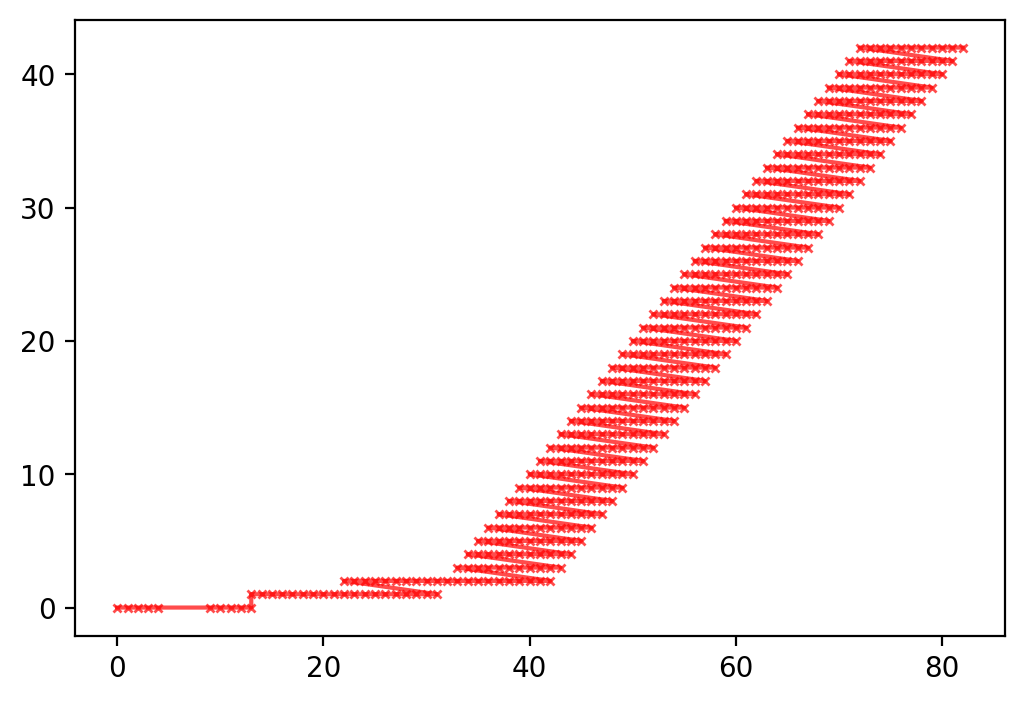

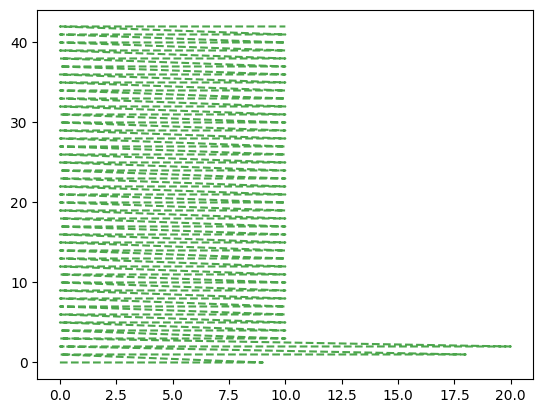

In [21]:
fig = plt.figure(dpi=200, figsize=(6,4))


# plt.semilogy(history['epoch'], history['test_loss'], '-og', markersize=3.0, alpha=.7)
plt.plot(history['epoch'], history['fit_number'], '-xr', markersize=3.0, alpha=.7)
plt.show()
plt.plot(history['fit_epoch'], history['fit_number'], '--g', markersize=3.0, alpha=.7)


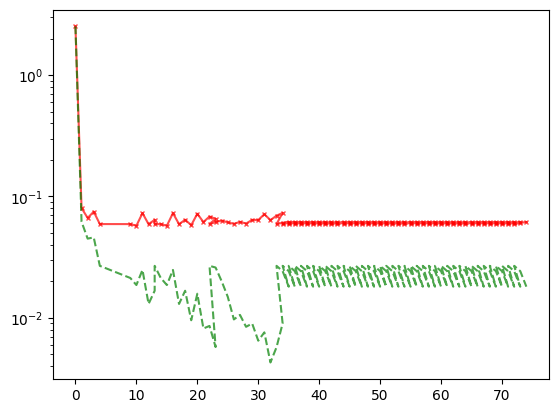

In [28]:
plt.semilogy(retained["epoch"], retained["test_loss"], "-xr", markersize=3.0, alpha=0.7)
plt.semilogy(
    retained["epoch"], retained["trained_loss"], "--g", markersize=3.0, alpha=0.7
)

In [32]:
history["masked_parameter_count"]

0      0
1      0
2      0
3      0
4      0
      ..
485    0
486    0
487    0
488    0
489    0
Name: masked_parameter_count, Length: 490, dtype: int8

/home/ctripp/dmp/env0/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  func(*args, **kwargs)


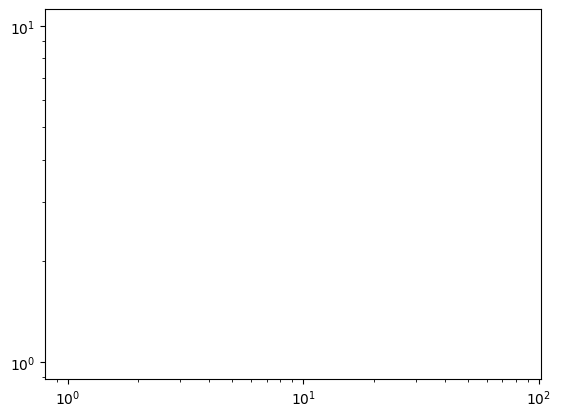

In [30]:
plt.loglog(history["epoch"], history["masked_parameter_count"], "-xr", markersize=3.0, alpha=0.7)

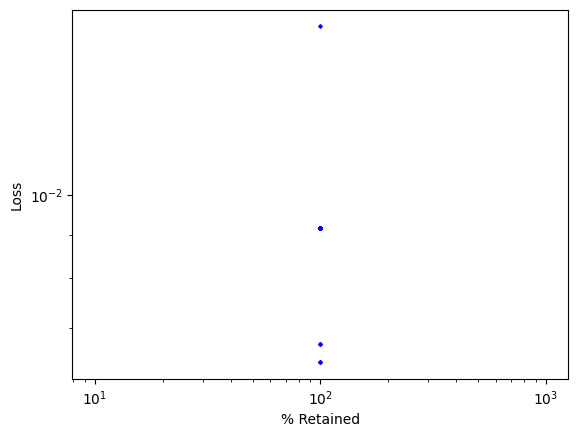

Text(0, 0.5, '% Error')

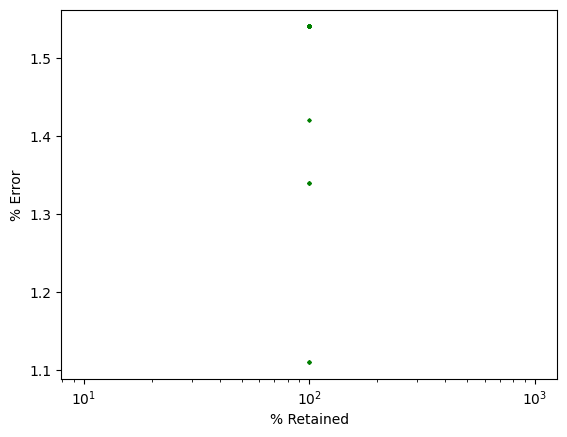

In [27]:
retained = history.loc[history["retained"] == True]
trained = history.loc[history.groupby(["fit_number"])["fit_epoch"].transform("idxmax")]

plt.loglog(
    100 * (1 - (trained["masked_parameter_count"]) / trained["free_parameter_count"]),
    trained["train_loss"],
    ".b",
    markersize=3.0,
    alpha=0.7,
)
plt.xlabel("% Retained")
plt.ylabel("Loss")

plt.show()
plt.semilogx(
    100 * (1 - (trained["masked_parameter_count"]) / trained["free_parameter_count"]),
    100 * (1 - trained["test_accuracy"]),
    ".g",
    markersize=3.0,
    alpha=0.7,
)
plt.xlabel("% Retained")
plt.ylabel("% Error")
# plt.semilogy(retained['epoch'], retained['trained_loss'], '--g', markersize=3.0, alpha=.7)

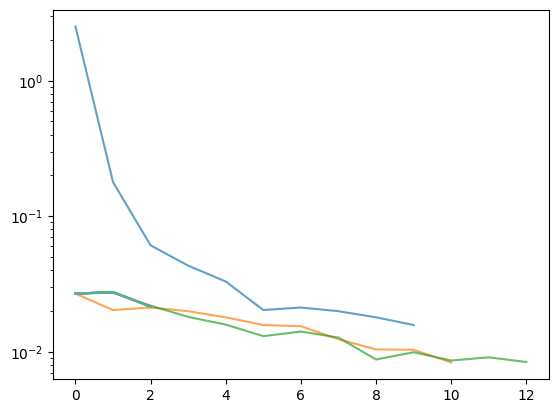

In [24]:

x = retained.loc[retained["fit_number"] < 10]
for fit_number, fit in x.groupby(["fit_number"]):
    plt.semilogy(
        fit["fit_epoch"],
        fit["train_loss"],
        "-",
        markersize=3.0,
        alpha=0.7,
    )

# plt.semilogy(retained['fit_epoch'], retained['test_loss'], '-xr', markersize=3.0, alpha=.7)

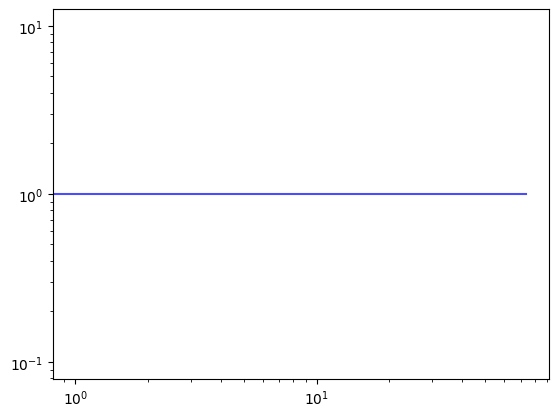

In [25]:
plt.loglog(
    retained["epoch"],
    (retained["free_parameter_count"] - retained["masked_parameter_count"]) / retained["free_parameter_count"],
    "-b",
    markersize=3.0,
    alpha=0.7,
)

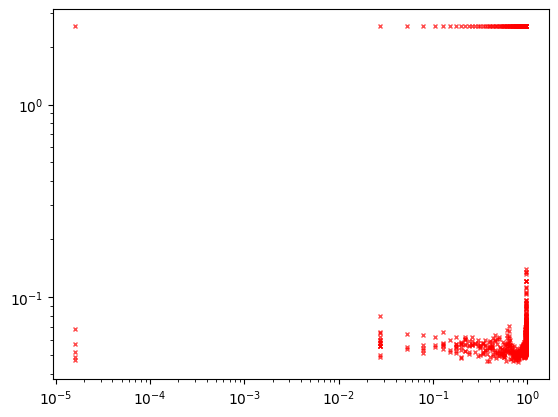

In [17]:
retained = history.loc[history["retained"] == True]
plt.loglog((1 + retained['masked_parameter_count']) / retained['free_parameter_count'], retained['test_loss'], 'xr', markersize=3.0, alpha=.7)

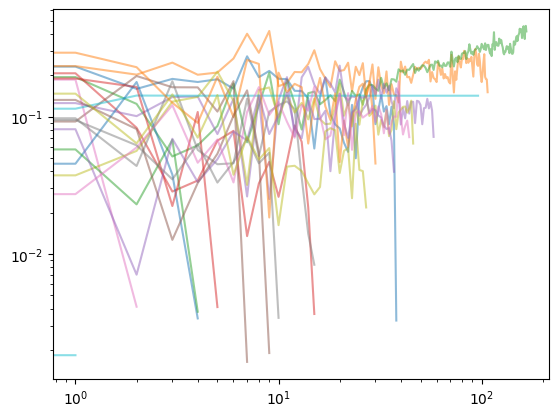

In [18]:
import h5py as h5
import hdf5plugin


def extract_trajectories(parameter_dataset, parameter_indicies, epochs):
    parameter_values = parameter_dataset[parameter_indicies, :]

    trajectories = np.ndarray(shape=(len(parameter_indicies), len(epochs)))
    for i, (epoch, sequence_number) in enumerate(epochs):
        parameters_at_epoch = parameter_values[:, sequence_number]
        trajectories[:, i] = parameters_at_epoch

    return trajectories


# scp eagle:/projects/modularai/dmp/dmp/model_data/c1a3792d-c30d-4b55-9ca4-d1bbcc59518c.h5 .
dmp_path = "/home/ctripp/dmp/dmp/"
model_data_dir = os.path.join(dmp_path, "model_data")
checkpoint_path = os.path.join(model_data_dir, f"{run_id}.h5")
with h5.File(checkpoint_path, "r") as h5_file:
    (
        epoch_dataset,
        parameter_dataset,
        optimizer_datasets,
    ) = model_serialization.get_datasets_from_model_file(h5_file, None)

    global_epoch = epoch_dataset[0, :]
    fit_number = epoch_dataset[1, :]
    fit_epoch = epoch_dataset[2, :]
    epoch_marker = epoch_dataset[3, :]

    epochs = []
    for i in range(epoch_dataset.shape[1]):
        epoch = TrainingEpoch(
            global_epoch[i], fit_number[i], fit_epoch[i], epoch_marker[i]
        )

        if history.loc[
            (history["epoch"] == epoch.epoch)
            & (history["fit_number"] == epoch.fit_number)
            & (history["fit_epoch"] == epoch.fit_epoch)
            & (history["retained"])
        ].empty:
            continue
        epochs.append(
            (
                epoch,
                i,
            )
        )
    epochs.sort()

    initial_epochs = [tup for tup in epochs if tup[0].fit_epoch == 0]
    final_epochs = [tup for tup in epochs if tup[0].marker != 0]

    # parameter_indicies = list(range(40))
    num_samples = 20
    num_samples = min(num_samples, parameter_dataset.shape[0])
    parameter_indicies = np.random.choice(
        parameter_dataset.shape[0], replace=False, size=num_samples
    )
    parameter_indicies = list(np.sort(parameter_indicies))

    initial_trajectories = extract_trajectories(
        parameter_dataset, parameter_indicies, initial_epochs
    )
    final_trajectories = extract_trajectories(
        parameter_dataset, parameter_indicies, final_epochs
    )

    # global_epoch = np.fromiter(
    #     (epoch.epoch for epoch, sequence_number in epochs), dtype=int
    # )
    # for i in range(trajectories.shape[0]):
    #     plt.loglog(global_epoch, trajectories[i, :], "-", alpha=0.5)
    # for i in range(initial_trajectories.shape[0]):
    #     plt.semilogy(
    #         list(range(len(epochs))), initial_trajectories[i, :], "-", alpha=0.5
    #     )

    for i in range(final_trajectories.shape[0]):
        plt.loglog(list(range(len(final_epochs))), np.abs(final_trajectories[i, :]), "-", alpha=0.5)
    # for epoch, sequence_number in epochs:
    # if epoch.fit_epoch == 0:
    #     plt.axvline(x=epoch.epoch, color="r", alpha=0.5)

In [19]:
print(epoch_dataset[:,:])

RuntimeError: Unable to synchronously get dataspace (invalid dataset identifier)

In [ ]:
with h5.File(checkpoint_path, "r") as h5_file:
    (
        epoch_dataset,
        parameter_dataset,
        optimizer_datasets,
    ) = model_serialization.get_datasets_from_model_file(h5_file, None)

    epoch = TrainingEpoch(epoch_dataset[0,0],
                          epoch_dataset[1,0],
                          epoch_dataset[2,0],
                          epoch_dataset[3,0],)

model = experiment._make_model_from_network(network, metrics)
model_serialization.load_parameters(
        model.network.structure,
        model.keras_network.layer_to_keras_map,
        None,
        checkpoint_path,
        epoch,
        load_mask=True,
    )

0: [] -> (<class 'dmp.layer.input.Input'>: 0, (28, 28, 1), "dmp_8") -> [1]
1: [0] -> (<class 'dmp.layer.dense_conv.DenseConv'>: 156, (28, 28, 6), 5x5, s: 1x1, relu, kc:"<class 'dict'>: {'class': 'ParameterMask'}") -> [2]
2: [1] -> (<class 'dmp.layer.max_pool.MaxPool'>: 0, (14, 14, 6), s: 2x2) -> [3]
3: [2] -> (<class 'dmp.layer.dense_conv.DenseConv'>: 2416, (10, 10, 16), 5x5, s: 1x1, relu, kc:"<class 'dict'>: {'class': 'ParameterMask'}") -> [4]
4: [3] -> (<class 'dmp.layer.max_pool.MaxPool'>: 0, (5, 5, 16), s: 2x2) -> [5]
5: [4] -> (<class 'dmp.layer.flatten.Flatten'>: 0, (400,), ) -> [6]
6: [5] -> (<class 'dmp.layer.dense.Dense'>: 48120, (120,), x120, relu, kc:"<class 'dict'>: {'class': 'ParameterMask'}") -> [7]
7: [6] -> (<class 'dmp.layer.dense.Dense'>: 10164, (84,), x84, relu, kc:"<class 'dict'>: {'class': 'ParameterMask'}") -> [8]
8: [7] -> (<class 'dmp.layer.dense.Dense'>: 850, (10,), x10, softmax, kc:"<class 'NoneType'>: None") -> []
0: [] -> (<class 'dmp.layer.input.Input'>: 0,

TrainingEpoch(epoch=8, fit_number=1, fit_epoch=0, marker=0, sequence_number=0)

In [ ]:
for layer in model.network.structure.layers:
    print(layer)

In [ ]:
model.keras_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dmp_8 (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 dmp_7 (Conv2D)              (None, 28, 28, 6)         156       
                                                                 
 dmp_6 (MaxPooling2D)        (None, 14, 14, 6)         0         
                                                                 
 dmp_5 (Conv2D)              (None, 10, 10, 16)        2416      
                                                                 
 dmp_4 (MaxPooling2D)        (None, 5, 5, 16)          0         
                                                                 
 dmp_3 (Flatten)             (None, 400)               0         
                                                                 
 dmp_2 (Dense)               (None, 120)               48120 

 dmp_1 (Dense)               (None, 84)                10164     
                                                                 
 dmp_0 (Dense)               (None, 10)                850       
                                                                 
Total params: 61706 (241.04 KB)
Trainable params: 61706 (241.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
import tensorflow.keras as keras
for layer in model.network.structure.layers:
    layer_info = model.keras_network.layer_to_keras_map.get(layer, None)
    if layer_info is None:
        continue

    keras_layer = layer_info.keras_layer
    if keras_layer is None or not isinstance(keras_layer, keras.layers.Layer):
        continue

    for i, variable in enumerate(keras_layer.variables):  # type: ignore
        print(f'layer:{layer} variable {i} with name {variable.name} and shape {variable.shape}')

layer:<dmp.layer.dense.Dense object at 0x7fe64c287fa0> variable 0 with name dmp_0/kernel:0 and shape (84, 10)
layer:<dmp.layer.dense.Dense object at 0x7fe64c287fa0> variable 1 with name dmp_0/bias:0 and shape (10,)
layer:<dmp.layer.dense.Dense object at 0x7fe64c287eb0> variable 0 with name dmp_1/kernel:0 and shape (120, 84)
layer:<dmp.layer.dense.Dense object at 0x7fe64c287eb0> variable 1 with name dmp_1/bias:0 and shape (84,)
layer:<dmp.layer.dense.Dense object at 0x7fe64c287f10> variable 0 with name dmp_2/kernel:0 and shape (400, 120)
layer:<dmp.layer.dense.Dense object at 0x7fe64c287f10> variable 1 with name dmp_2/bias:0 and shape (120,)
layer:<dmp.layer.dense_conv.DenseConv object at 0x7fe64c287760> variable 0 with name dmp_5/kernel:0 and shape (5, 5, 6, 16)
layer:<dmp.layer.dense_conv.DenseConv object at 0x7fe64c287760> variable 1 with name dmp_5/bias:0 and shape (16,)
layer:<dmp.layer.dense_conv.DenseConv object at 0x7fe64c287d60> variable 0 with name dmp_7/kernel:0 and shape (5,

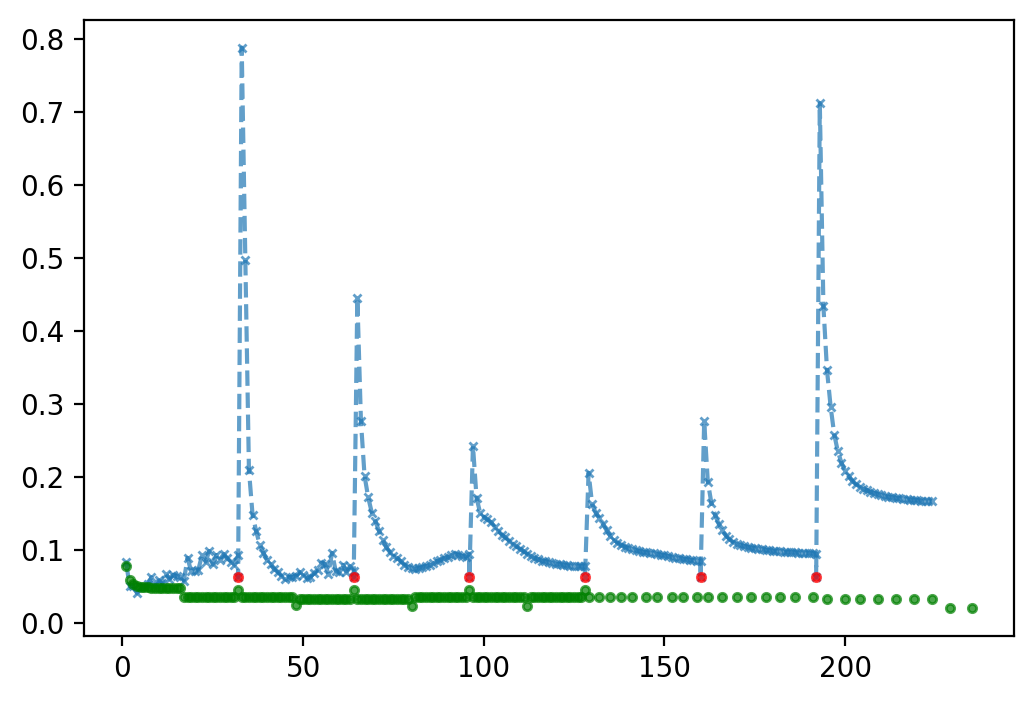

In [ ]:
fig = plt.figure(dpi=200, figsize=(6,4))

plt.plot(history['epoch'], history['test_loss'], '--x', markersize=3.0, alpha=.7)
new_iterations = history[history['model_epoch'] == 0]
plt.plot(by_epoch['epoch'], by_epoch['test_loss_cmin_quantile_50'], 'og', markersize=3.0, alpha=.7)

plt.plot(new_iterations['epoch'], new_iterations['test_loss'], 'or', markersize=3.0, alpha=.7)


In [ ]:
history.columns

Index(['test_loss', 'trained_categorical_crossentropy', 'trained_accuracy',
       'train_categorical_crossentropy', 'free_parameter_count',
       'train_accuracy', 'retained', 'validation_categorical_crossentropy',
       'masked_parameter_count', 'validation_accuracy', 'trainms_ms',
       'trained_ms', 'train_loss', 'test_ms', 'model_epoch', 'epoch',
       'validation_loss', 'seed_number', 'test_accuracy', 'model_number',
       'test_categorical_crossentropy', 'trained_loss', 'epoch_startms_ms'],
      dtype='object')

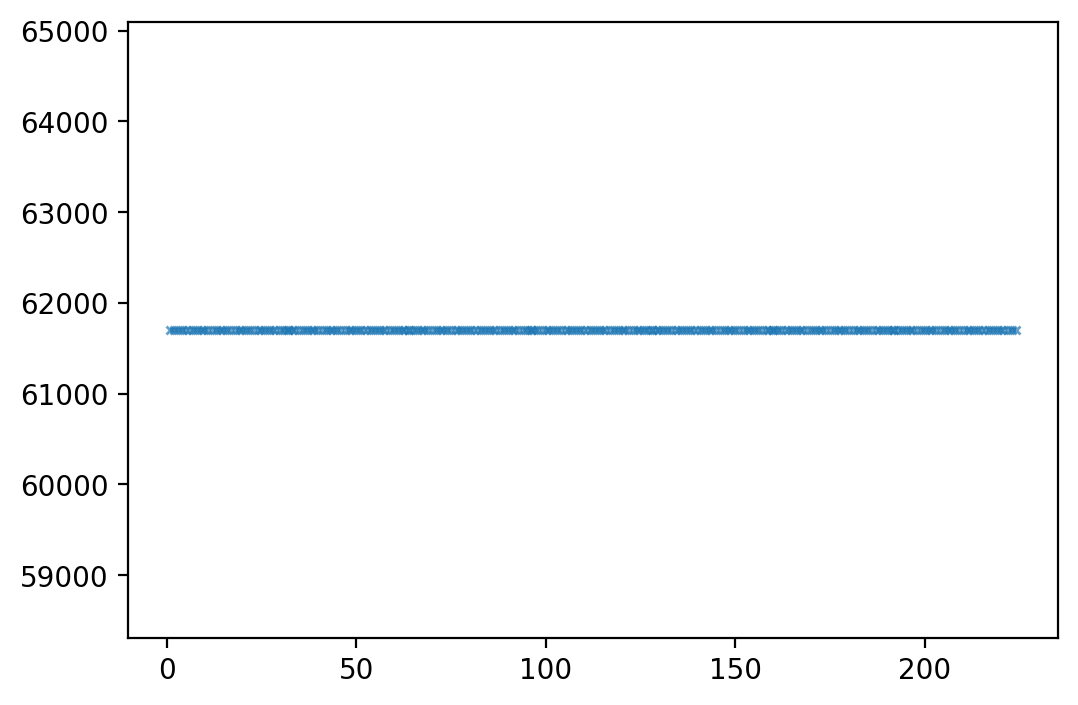

In [ ]:
fig = plt.figure(dpi=200, figsize=(6,4))

plt.plot(history['epoch'], history['free_parameter_count'], '--x', markersize=3.0, alpha=.7)


In [ ]:

credentials = jobqueue.load_credentials('dmp')
with ConnectionManager(credentials) as connection:
    with connection.cursor(binary=True) as cursor:
        query = psycopg.sql.SQL("""
SELECT
    by_epoch
FROM
    experiment2 e
WHERE TRUE
    AND e.experiment_id = 'b0d415cf-f228-c439-0480-3337c543c2e4'
LIMIT 1;
""")

        cursor.execute(query, binary=True)
        row = cursor.fetchone()
        with io.BytesIO(row[0]) as buffer:
            by_epoch = pyarrow.parquet.read_table(
                pyarrow.PythonFile(buffer, mode='r')).to_pandas()


by_epoch.describe()
by_epoch

,epoch,count,model_epoch_quantile_0,model_epoch_quantile_25,model_epoch_quantile_50,model_epoch_quantile_75,model_epoch_quantile_100,trained_categorical_crossentropy_quantile_0,trained_categorical_crossentropy_quantile_25,trained_categorical_crossentropy_quantile_50,...,test_accuracy_cmax_quantile_0,test_accuracy_cmax_quantile_25,test_accuracy_cmax_quantile_50,test_accuracy_cmax_quantile_75,test_accuracy_cmax_quantile_100,validation_accuracy_cmax_quantile_0,validation_accuracy_cmax_quantile_25,validation_accuracy_cmax_quantile_50,validation_accuracy_cmax_quantile_75,validation_accuracy_cmax_quantile_100
0,1,8,1.0,1.0,1.0,1.0,1.0,0.060437,0.061399,0.066523,...,0.9734,0.973925,0.97625,0.977575,0.9798,0.974000,0.975571,0.976571,0.977286,0.980571
1,2,8,2.0,2.0,2.0,2.0,2.0,0.039023,0.039946,0.041580,...,0.9762,0.980350,0.98225,0.982875,0.9843,0.980000,0.981071,0.981429,0.982143,0.985143
2,3,8,3.0,3.0,3.0,3.0,3.0,0.028624,0.030501,0.035552,...,0.9810,0.981500,0.98280,0.983900,0.9866,0.980857,0.981643,0.983000,0.984071,0.989429
3,4,8,4.0,4.0,4.0,4.0,4.0,0.019772,0.025258,0.027370,...,0.9812,0.981675,0.98450,0.985625,0.9885,0.980857,0.983214,0.983857,0.986857,0.989429
4,5,8,5.0,5.0,5.0,5.0,5.0,0.017522,0.022112,0.024034,...,0.9816,0.984450,0.98495,0.985650,0.9885,0.980857,0.983929,0.985429,0.987071,0.989429
5,6,8,6.0,6.0,6.0,6.0,6.0,0.016902,0.019114,0.019577,...,0.9819,0.984825,0.98520,0.986550,0.9885,0.984000,0.984786,0.985571,0.987071,0.989429
6,7,8,7.0,7.0,7.0,7.0,7.0,0.014243,0.016146,0.017878,...,0.9851,0.985725,0.98655,0.988050,0.9885,0.984000,0.985143,0.986000,0.987214,0.989429
7,8,8,8.0,8.0,8.0,8.0,8.0,0.010488,0.012256,0.017983,...,0.9851,0.986250,0.98745,0.988500,0.9888,0.984000,0.985143,0.986143,0.987214,0.989714
8,9,8,9.0,9.0,9.0,9.0,9.0,0.010544,0.011973,0.016272,...,0.9851,0.986250,0.98775,0.988500,0.9891,0.984000,0.985143,0.986143,0.987214,0.990000
9,10,8,10.0,10.0,10.0,10.0,10.0,0.008422,0.011188,0.012371,...,0.9859,0.986800,0.98775,0.988500,0.9897,0.984000,0.985143,0.986714,0.988643,0.990000


In [ ]:
df.columns

Index(['experiment_id', 'old_experiment_id', 'experiment_attrs', 'run_id',
       'job_id', 'slurm_job_id', 'run_timestamp', 'seed', 'task_version',
       'num_nodes',
       ...
       'precision', 'worker_id', 'record_model', 'record_times',
       'python_version', 'record_metrics', 'tensorflow_version',
       'tensorflow_strategy', 'record_post_training_metrics',
       'make_batch_optimizer_butter_growth_eagle_gpu_1'],
      dtype='object', length=105)

In [ ]:
df['run_history'].iloc[0]['train_loss']


0      1.247540
1      0.898057
2      0.847315
3      0.850349
4      0.847144
         ...   
145    0.225552
146    0.213775
147    0.213580
148    0.213284
149    0.210847
Name: train_loss, Length: 150, dtype: float32

In [ ]:
run_df = df['run_history'].iloc[0]
run_df['trained_loss'] - run_df['train_loss']

0      0.000000
1     -0.047707
2      0.003034
3      0.000000
4     -0.001494
         ...   
145    0.026551
146   -0.015600
147   -0.015426
148   -0.008199
149    0.011152
Length: 150, dtype: float32